### Import Libraries

In [14]:
import pandas as pd
import numpy as np
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import seaborn as sn
from pathlib import Path

from sentence_transformers import SentenceTransformer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

### Load Data

In [3]:
data_dir = Path().cwd() / "data"

train_df = pd.read_csv( data_dir / "train.csv")
test_df = pd.read_csv( data_dir / "test.csv")

In [4]:
print("Train Size", train_df.shape)
print("Test Size", test_df.shape)

Train Size (200000, 3)
Test Size (50000, 3)


### Using Embedding for normal muilt-class Classification

In [5]:
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
# EMBEDDING_MODEL = "sentence-transformers/all-mpnet-base-v2"

embedding_model = SentenceTransformer(EMBEDDING_MODEL)

In [6]:
train_df.columns

Index(['title', 'category', 'label'], dtype='object')

In [7]:
X_train = embedding_model.encode(train_df["title"])
y_train = train_df["label"]

X_test = embedding_model.encode(test_df["title"])
y_test = test_df["label"]

In [8]:
X_train.shape, X_test.shape

((200000, 384), (50000, 384))

#### KNeighbors Classifier

In [9]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_micro": f1_score(y_test, y_pred, average="micro"),
    "f1_macro": f1_score(y_test, y_pred, average="macro"),
    "precision": precision_score(y_test, y_pred, average="macro"),
    "recall": recall_score(y_test, y_pred, average="macro")
}

In [11]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize='pred'))

labels = {}
for i,l in test_df[["label", "category"]].drop_duplicates().values:
    labels[i] = l


cm.columns = [labels[i] for i in cm.columns]
cm.index = [labels[i] for i in cm.index]

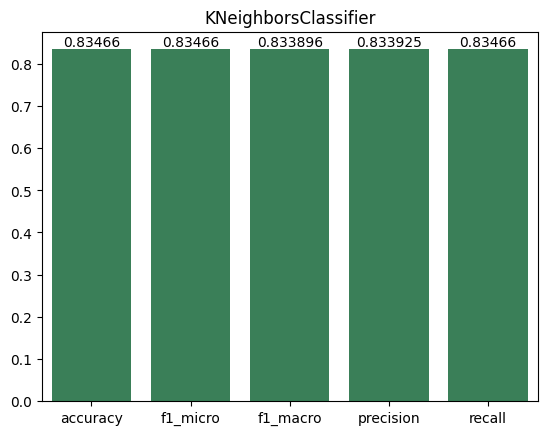

In [39]:
ax = sn.barplot(metrics, color="seagreen")
ax.bar_label(ax.containers[0], fontsize=10)
plt.title(f"KNeighborsClassifier")
plt.show()

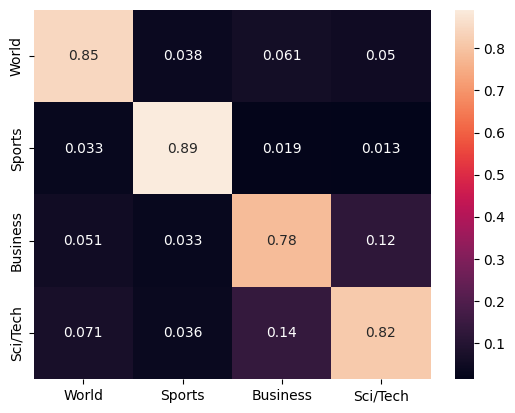

In [16]:
hm = sn.heatmap(cm, annot=True)
plt.show()

### PCA

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [24]:
pca = PCA()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [25]:
var_thr = 0.9
max_var = np.argmax(np.cumsum(np.cumsum(pca.explained_variance_ratio_) <= var_thr))

X_train_pca = X_train_pca[:, :max_var]
X_test_pca = X_test_pca[:, :max_var]

X_train_pca.shape

(200000, 199)

In [26]:
classifier = KNeighborsClassifier()
classifier.fit(X_train_pca, y_train)
y_pred = classifier.predict(X_test_pca)

In [27]:
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_micro": f1_score(y_test, y_pred, average="micro"),
    "f1_macro": f1_score(y_test, y_pred, average="macro"),
    "precision": precision_score(y_test, y_pred, average="macro"),
    "recall": recall_score(y_test, y_pred, average="macro")
}

In [28]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize='pred'))

labels = {}
for i,l in test_df[["label", "category"]].drop_duplicates().values:
    labels[i] = l


cm.columns = [labels[i] for i in cm.columns]
cm.index = [labels[i] for i in cm.index]

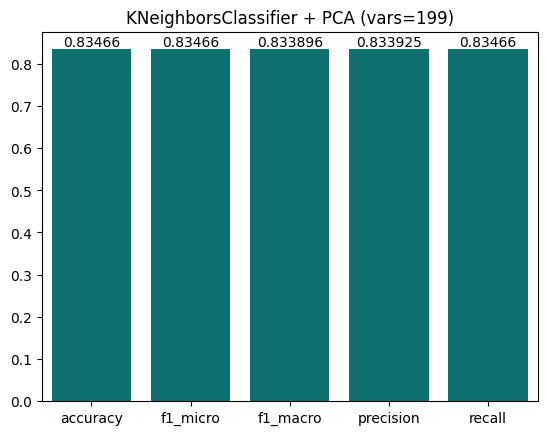

In [34]:
ax = sn.barplot(metrics, color="teal")
ax.bar_label(ax.containers[0], fontsize=10)
plt.title(f"KNeighborsClassifier + PCA (vars={max_var})")
plt.show()

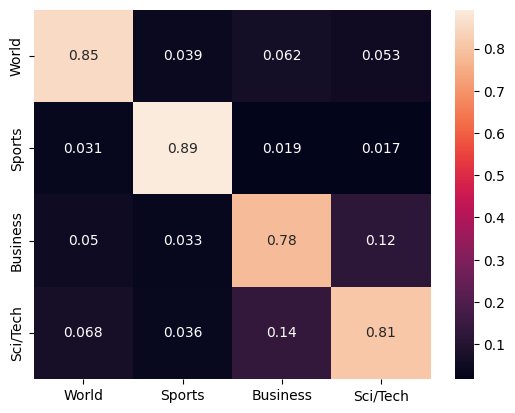

In [30]:
hm = sn.heatmap(cm, annot=True)
plt.show()